# (S)NPE-C on norm_norm_diffuse_1d

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import yaml

# Import local packages
from examples.unif_norm import (
    prior_pdf,
    get_approximate_posterior_density,
    true_posterior_pdf,
    approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_diff_against_x
)
from sbc.sbc_tools import plot_sbc_all
results_path = "/Users/Lieve/Documents/Masters Project/SBC-SBI/results/toy_examples/unif_norm/npe_c/"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Amortized NPE-C

Below, we plot the posterior approximation for amortized posteriors trained with varying `num_simulations`

In [2]:
multiple_amortized_posteriors_ID = 0
multiple_amortized_posteriors_name = f"multiple_amortized_posteriors_dict{multiple_amortized_posteriors_ID}"
path_to_multiple_amortized_posteriors = results_path + multiple_amortized_posteriors_name + ".pkl"

# Load dictionary of posteriors, density estimators, and configs
with open(path_to_multiple_amortized_posteriors, "rb") as f:
    multiple_amortized_posteriors_dict = pickle.load(f)

multiple_amortized_posteriors_list = multiple_amortized_posteriors_dict["amortized_posteriors"]
multiple_amortized_posteriors_configs_list = multiple_amortized_posteriors_dict["configs"]
multiple_amortized_posteriors_density_estimators_list = multiple_amortized_posteriors_dict["density_estimators"]

L = multiple_amortized_posteriors_configs_list[0]["L"]
U = multiple_amortized_posteriors_configs_list[0]["U"]
d = multiple_amortized_posteriors_configs_list[0]["d"]
sigma = multiple_amortized_posteriors_configs_list[0]["sigma"]

In [3]:
# Following code only works for d=1
x_observed = 0.8
num_plotting_samples = 10000
num_simulations_list = [multiple_amortized_posteriors_configs["num_simulations"] for multiple_amortized_posteriors_configs in multiple_amortized_posteriors_configs_list]
amortized_density_estimator_samples_list = [amortized_density_estimator.sample((num_plotting_samples,), condition=torch.tensor([[x_observed]])).detach().view(-1) for amortized_density_estimator in multiple_amortized_posteriors_density_estimators_list]
amortized_posterior_samples_list = [amortized_posterior.sample((num_plotting_samples,), x=x_observed, show_progress_bars=False).view(-1) for amortized_posterior in multiple_amortized_posteriors_list]

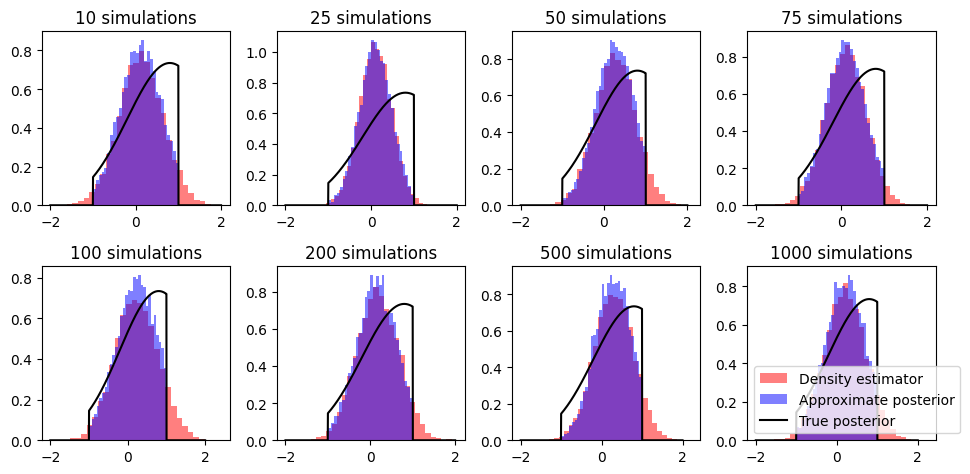

In [4]:
nrows, ncols = 2, 4
assert ncols * nrows == len(multiple_amortized_posteriors_list)
fig, ax = plt.subplots(figsize=(10,5), ncols=ncols, nrows=nrows)
#xlim0 = min([min(amortized_density_estimator_samples) for amortized_density_estimator_samples in amortized_density_estimator_samples_list])
#xlim1 = max([max(amortized_density_estimator_samples) for amortized_density_estimator_samples in amortized_density_estimator_samples_list])
mu_range = np.linspace(L-1, U+1, 1000)

bins=30
for k in range(len(multiple_amortized_posteriors_list)):
    i = k // ncols
    j = k % ncols
    ax[i,j].hist(amortized_density_estimator_samples_list[k], bins=bins, density=True, color="red", alpha=0.5, label="Density estimator")
    ax[i,j].hist(amortized_posterior_samples_list[k], bins=bins, density=True, color="blue", alpha=0.5, label="Approximate posterior")
    ax[i,j].plot(mu_range, true_posterior_pdf(mu_range, x_observed, L=L, U=U, sigma=sigma), color="k", label="True posterior")
    num_simulations = num_simulations_list[k]
    ax[i,j].set_title(f"{num_simulations} simulations")
    if k == len(multiple_amortized_posteriors_list) - 1:
        ax[i,j].legend()
title = ""
plt.suptitle(title)
plt.tight_layout()
plt.show()

Below, we plot the posterior approximation for a specific amortized posterior

In [5]:
amortized_posterior_ID = 0

# Load pre-trained amortized posterior
amortized_posterior_name = f"amortized_posterior{amortized_posterior_ID}"
path_to_amortized_posterior = results_path + amortized_posterior_name + ".pkl"
path_to_amortized_posterior_density_estimator = results_path + amortized_posterior_name + "_density_estimator" + ".pkl"
path_to_amortized_posterior_config = results_path + amortized_posterior_name + ".yaml"
path_to_amortized_posterior_simulations = results_path + amortized_posterior_name + "_simulations" + ".npz"

# Load posterior
with open(path_to_amortized_posterior, "rb") as f:
    amortized_posterior = pickle.load(f)

# Load density estimator
with open(path_to_amortized_posterior_density_estimator, "rb") as f:
    amortized_density_estimator = pickle.load(f)

# Turn DirectPosterior object into callable function
approximate_posterior_amortized = get_approximate_posterior_density(amortized_posterior)

# Load config
with open(path_to_amortized_posterior_config, "r") as f:
    amortized_posterior_config = yaml.safe_load(f)

# Load samples
amortized_posterior_simulations = np.load(path_to_amortized_posterior_simulations)

sigma = amortized_posterior_config["sigma"]
d = amortized_posterior_config["d"]
L = amortized_posterior_config["L"]
U = amortized_posterior_config["U"]

print("Amortized posterior config:")
amortized_posterior_config

Amortized posterior config:


{'L': -1.0,
 'U': 1.0,
 'd': 1,
 'force_first_round_loss': False,
 'num_simulations': 20000,
 'sigma': 1.0,
 'simulation_time': 0.2916700419999998,
 'total_time': 22.253233584,
 'training_time': 21.961563542}

In [6]:
x_observed = 0.8
amortized_density_estimator_samples = amortized_density_estimator.sample((num_plotting_samples,), condition=torch.tensor([[x_observed]])).detach().view(-1)
amortized_posterior_samples = amortized_posterior.sample((num_plotting_samples,), x=x_observed, show_progress_bars=False).view(-1)

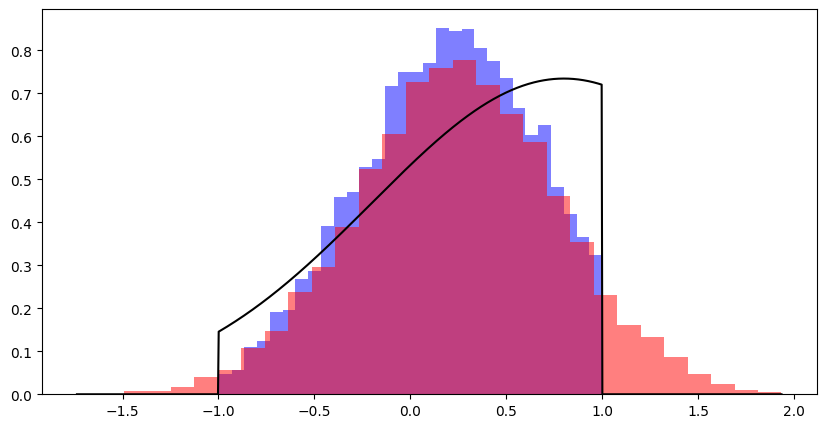

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

xlim0 = min(amortized_density_estimator_samples)
xlim1 = max(amortized_density_estimator_samples)
mu_range = np.linspace(xlim0, xlim1, 1000)

ax.hist(amortized_posterior_samples, density=True, bins=bins, color="blue", alpha=0.5)
ax.hist(amortized_density_estimator_samples, density=True, bins=bins, color="red", alpha=0.5)
ax.plot(mu_range, true_posterior_pdf(mu_range, x_observed, L=L, U=U, sigma=sigma), color="black")

plt.show()

Plot quantiles of amortized posterior for various values of $x_\text{observed}$.

- Without the training samples

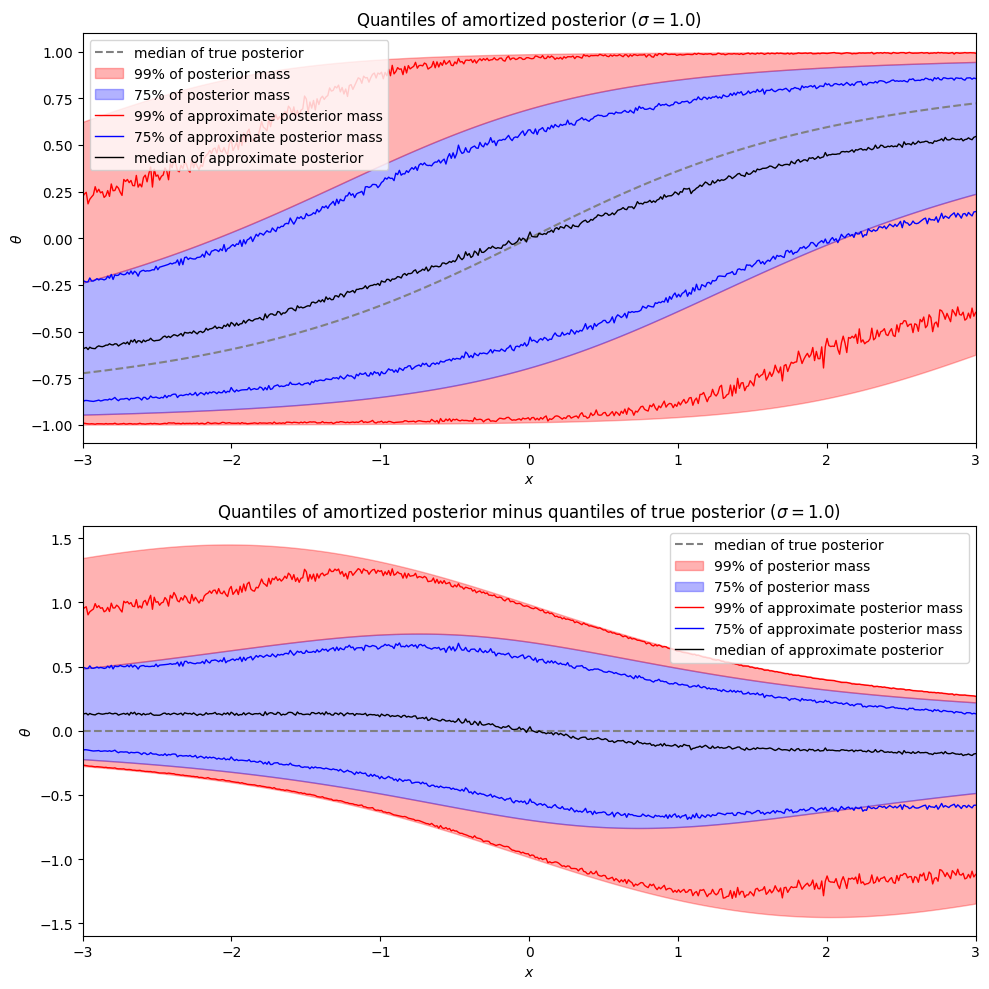

In [8]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(L-2,U+2,500)
quantiles = approximate_posterior_quantiles_against_x(amortized_posterior, x_range)

title = "Quantiles of amortized posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[0])

title = "Quantiles of amortized posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[1])

plt.tight_layout()
plt.show()

- With the training samples

In [9]:
# Retrieve samples
amortized_posterior_parameter_samples = amortized_posterior_simulations["parameter_samples"].reshape(-1)
amortized_posterior_data_samples = amortized_posterior_simulations["data_samples"].reshape(-1)
amortized_posterior_samples = {"parameter_samples": amortized_posterior_parameter_samples,
                                "data_samples": amortized_posterior_data_samples}

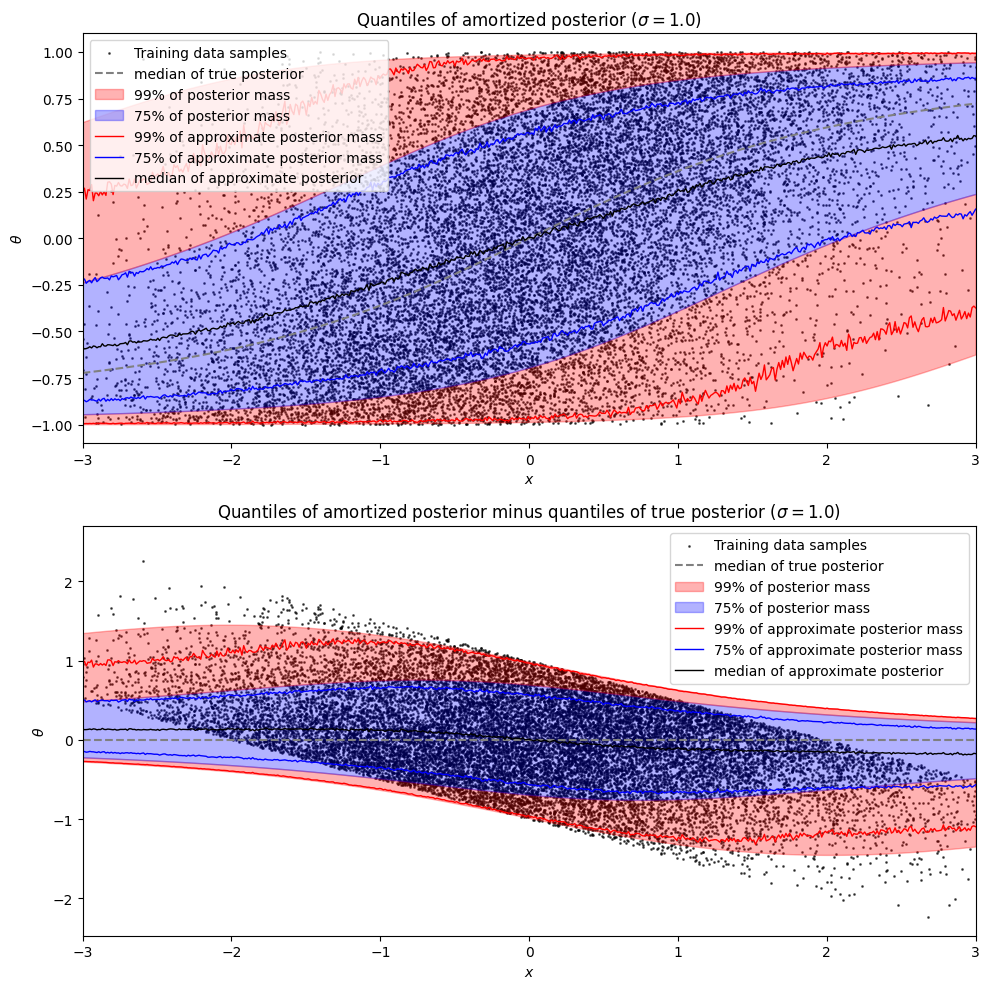

In [10]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(L-2,U+2,500)
quantiles = approximate_posterior_quantiles_against_x(amortized_posterior, x_range)

title = "Quantiles of amortized posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[0], samples=amortized_posterior_samples)

title = "Quantiles of amortized posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[1], samples=amortized_posterior_samples)

plt.tight_layout()
plt.show()

Below, we plot the leakage factor (proportion of density estimator area lying outside of $[L,U]^d$) against different hyperparameters:

In [24]:
amortized_leakage_factor_dict_ID = 3

amortized_leakage_factor_dict_name = f"amortized_leakage_factor_dict{amortized_leakage_factor_dict_ID}"
path_to_amortized_leakage_factor_dict = results_path + amortized_leakage_factor_dict_name + ".npz"
path_to_amortized_leakage_factor_dict_config = results_path + amortized_leakage_factor_dict_name + ".yaml"

# Load leakage factors
amortized_leakage_factor_dict = np.load(path_to_amortized_leakage_factor_dict)
amortized_leakage_factor_dict = dict(amortized_leakage_factor_dict)
# Load config
with open(path_to_amortized_leakage_factor_dict_config, "r") as f:
    amortized_leakage_factor_dict_config = yaml.safe_load(f)

amortized_leakage_factor_dict_config

{'L': -1.0,
 'U': 1.0,
 'd': 10,
 'd_list': None,
 'force_first_round_loss': False,
 'num_posterior_samples_per_leakage_factor': 10000,
 'num_posteriors_per_leakage_factor': 100,
 'num_simulations': 20000,
 'num_simulations_list': [25,
  50,
  100,
  200,
  250,
  500,
  1000,
  2500,
  5000,
  10000,
  15000,
  20000],
 'sigma': 1.0,
 'x_observed': [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]}

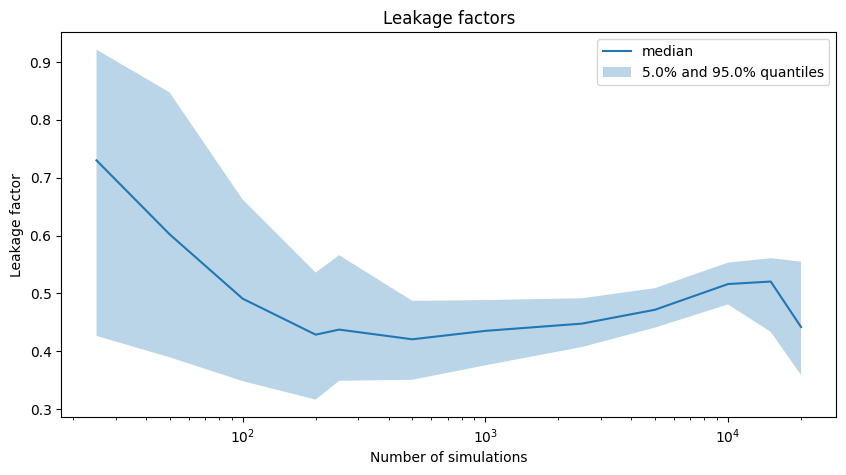

In [78]:
def plot_leakage_factors(leakage_factor_dict, alpha=0.1, ax=None, logscale=True, type="num_simulations"):
    user_defined_ax = ax
    if not ax:
        fig, ax = plt.subplots(figsize=(10,5))

    if not type == "num_simulations":
        raise NotImplementedError("YET TO IMPLEMENT TYPES OTHER THAN num_simulations")

    num_simulations_list = []
    median_leakage_factor_list = []
    lq_leakage_factor_list = []
    uq_leakage_factor_list = []

    for k, v in leakage_factor_dict.items():
        num_simulations = int(k[18:])
        num_simulations_list.append(num_simulations)
        median = np.quantile(v, 0.5)
        uq = np.quantile(v, 1 - alpha / 2)
        lq = np.quantile(v, alpha / 2)
        median_leakage_factor_list.append(median)
        lq_leakage_factor_list.append(lq)
        uq_leakage_factor_list.append(uq)
    
    ax.plot(num_simulations_list, median_leakage_factor_list, label="median")
    ax.fill_between(num_simulations_list, lq_leakage_factor_list, uq_leakage_factor_list, alpha=0.3, label=f"{100*(alpha / 2)}% and {100*(1 - alpha / 2)}% quantiles")
    
    if logscale:
        ax.set_xscale('log')
    ax.set_xlabel("Number of simulations")
    ax.set_ylabel("Leakage factor")
    ax.set_title("Leakage factors")

    plt.legend()
    plt.show()

plot_leakage_factors(amortized_leakage_factor_dict)

## SBC on amortized NPE-C

- $d=1$ example

In [45]:
amortized_sbc_ID = 0
amortized_sbc_amortized_posterior_ID = 0

# Load pre-trained amortized sbc ranks
amortized_ranks_name = f"amortized_sbc_ranks{amortized_sbc_ID}_amortized_posterior{amortized_sbc_amortized_posterior_ID}"
path_to_amortized_ranks = results_path + amortized_ranks_name + ".npz"
path_to_amortized_ranks_config = results_path + amortized_ranks_name + ".yaml"
path_to_amortized_ranks_simulations = results_path + amortized_ranks_name + "_simulations" + ".npz"

# Load sbc ranks
amortized_ranks = np.load(path_to_amortized_ranks)
amortized_ranks = amortized_ranks[""] # Saved as a dict by default

# Load config
with open(path_to_amortized_ranks_config, "r") as f:
    amortized_ranks_config = yaml.safe_load(f)

# Load samples
amortized_ranks_simulations = np.load(path_to_amortized_ranks_simulations)

N_iter = amortized_ranks_config["N_iter"]
N_samp = amortized_ranks_config["N_samp"]

print(f"Amortized SBC config:")
amortized_ranks_config

Amortized SBC config:


{'L': -1.0,
 'N_iter': 1000,
 'N_samp': 5000,
 'U': 1.0,
 'amortized_posterior_ID': 0,
 'd': 1,
 'sigma': 1.0,
 'test_function_name': None,
 'total_sbc_time': 11.606817916}

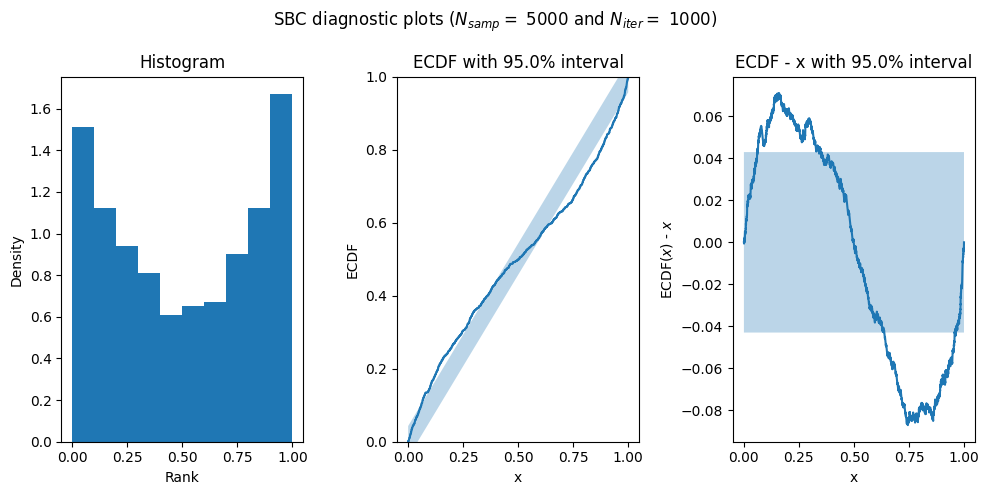

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [46]:
# Plot amortized ranks
plot_sbc_all(ranks=amortized_ranks, N_samp=N_samp)

- $d=10$ example

In [47]:
amortized_sbc_ID = 0
amortized_sbc_amortized_posterior_ID = 1

# Load pre-trained amortized sbc ranks
amortized_ranks_name = f"amortized_sbc_ranks{amortized_sbc_ID}_amortized_posterior{amortized_sbc_amortized_posterior_ID}"
path_to_amortized_ranks = results_path + amortized_ranks_name + ".npz"
path_to_amortized_ranks_config = results_path + amortized_ranks_name + ".yaml"

# Load sbc ranks
amortized_ranks = np.load(path_to_amortized_ranks)
amortized_ranks = dict(amortized_ranks)

# Load config
with open(path_to_amortized_ranks_config, "r") as f:
    amortized_ranks_config = yaml.safe_load(f)

N_iter = amortized_ranks_config["N_iter"]
N_samp = amortized_ranks_config["N_samp"]

print(f"Amortized SBC config:")
amortized_ranks_config

Amortized SBC config:


{'L': -10.0,
 'N_iter': 1000,
 'N_samp': 5000,
 'U': 10.0,
 'amortized_posterior_ID': 1,
 'd': 10,
 'sigma': 1.0,
 'test_function_name': ['projection0',
  'projection1',
  'projection2',
  'projection3',
  'projection4',
  'projection5',
  'projection6',
  'projection7',
  'projection8',
  'projection9',
  'squared_norm'],
 'total_sbc_time': 141.181487417}

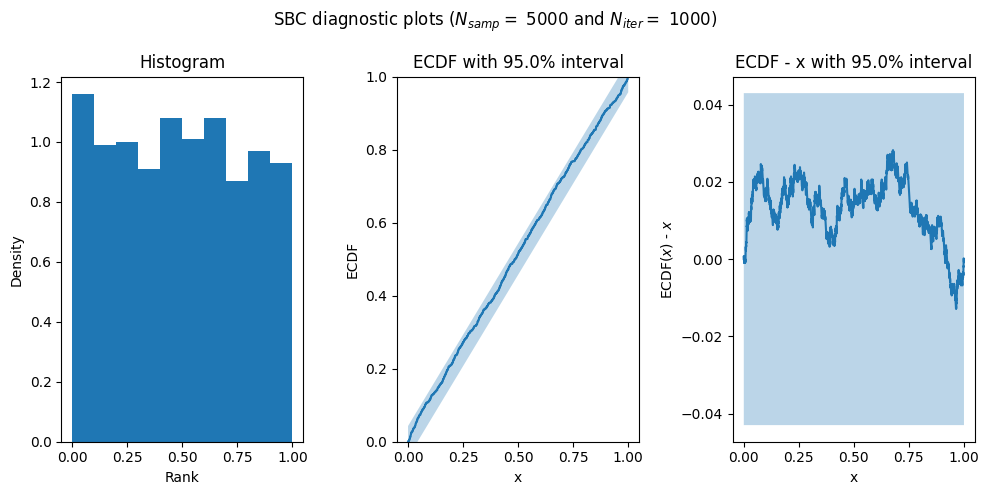

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [51]:
plot_sbc_all(ranks=amortized_ranks["projection3"], N_samp=N_samp)

# Sequential NPE-C (SNPE-C)

Below, we plot the posterior approximation for sequential posteriors trained with varying `(num_sequential_rounds, num_simulations_per_round)`

In [15]:
multiple_sequential_posteriors_ID = 1
multiple_sequential_posteriors_name = f"multiple_sequential_posteriors_dict{multiple_sequential_posteriors_ID}"
path_to_multiple_sequential_posteriors = results_path + multiple_sequential_posteriors_name + ".pkl"

# Load dictionary of posteriors, density estimators, and configs
with open(path_to_multiple_sequential_posteriors, "rb") as f:
    multiple_sequential_posteriors_dict = pickle.load(f)

multiple_sequential_posteriors_list = multiple_sequential_posteriors_dict["sequential_posteriors"]
multiple_sequential_posteriors_configs_list = multiple_sequential_posteriors_dict["configs"]
multiple_sequential_posteriors_density_estimators_list = multiple_sequential_posteriors_dict["density_estimators"]

L = multiple_sequential_posteriors_configs_list[0]["L"]
U = multiple_sequential_posteriors_configs_list[0]["U"]
d = multiple_sequential_posteriors_configs_list[0]["d"]
sigma = multiple_sequential_posteriors_configs_list[0]["sigma"]
x_observed = multiple_sequential_posteriors_configs_list[0]["x_observed"]


In [16]:
num_plotting_samples = 10000
num_simulations_per_round_list = [multiple_sequential_posteriors_configs["num_simulations_per_round"] for multiple_sequential_posteriors_configs in multiple_sequential_posteriors_configs_list]
num_sequential_rounds_list = [multiple_sequential_posteriors_configs["num_sequential_rounds"] for multiple_sequential_posteriors_configs in multiple_sequential_posteriors_configs_list]

sequential_density_estimator_samples_list = [sequential_density_estimator.sample((num_plotting_samples,), condition=torch.tensor([[x_observed]])).detach().view(-1) for sequential_density_estimator in multiple_sequential_posteriors_density_estimators_list]
sequential_posterior_samples_list = [sequential_posterior.sample((num_plotting_samples,), x=x_observed, show_progress_bars=False).view(-1) for sequential_posterior in multiple_sequential_posteriors_list]
leakage_rate_list = [torch.sum((sequential_density_estimator_samples < L) | (sequential_density_estimator_samples > U)) / num_plotting_samples for sequential_density_estimator_samples in sequential_density_estimator_samples_list]

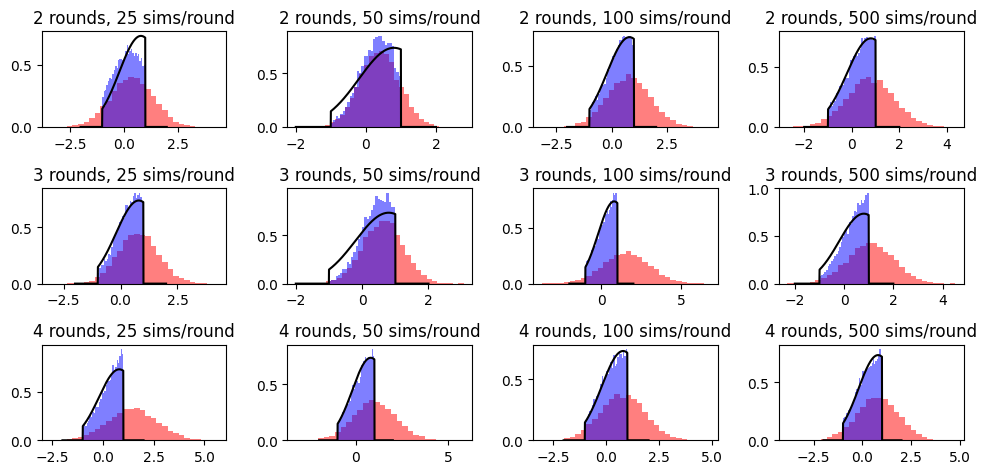

In [17]:
nrows, ncols = 3, 4
assert ncols * nrows == len(multiple_sequential_posteriors_list)
fig, ax = plt.subplots(figsize=(10,5), ncols=ncols, nrows=nrows)
#xlim0 = min([min(sequential_density_estimator_samples) for sequential_density_estimator_samples in sequential_density_estimator_samples_list])
#xlim1 = max([max(sequential_density_estimator_samples) for sequential_density_estimator_samples in sequential_density_estimator_samples_list])
mu_range = np.linspace(L-1, U+1, 1000)

bins=30
for k in range(len(multiple_sequential_posteriors_list)):
    i = k // ncols
    j = k % ncols
    ax[i,j].hist(sequential_density_estimator_samples_list[k], bins=bins, density=True, color="red", alpha=0.5)
    ax[i,j].hist(sequential_posterior_samples_list[k], bins=bins, density=True, color="blue", alpha=0.5)
    ax[i,j].plot(mu_range, true_posterior_pdf(mu_range, x_observed, L=L, U=U, sigma=sigma), color="k")
    num_simulations_per_round = num_simulations_per_round_list[k]
    num_sequential_rounds = num_sequential_rounds_list[k]
    ax[i,j].set_title(f"{num_sequential_rounds} rounds, {num_simulations_per_round} sims/round")

title = ""
plt.suptitle(title)
plt.tight_layout()
plt.show()

Below, we plot the posterior approximation for a specific amortized posterior

In [18]:
sequential_posterior_ID = 0

# Load pre-trained posterior
sequential_posterior_name = f"sequential_posterior{sequential_posterior_ID}"
path_to_sequential_posterior = results_path + sequential_posterior_name + ".pkl"
path_to_sequential_density_estimator = results_path + sequential_posterior_name + "_density_estimator" + ".pkl"
path_to_sequential_posterior_config = results_path + sequential_posterior_name + ".yaml"
path_to_sequential_posterior_simulations = results_path + sequential_posterior_name + "_simulations" + ".npz"

# Load posterior
with open(path_to_sequential_posterior, "rb") as f:
    sequential_posterior = pickle.load(f)

# Load density estimator
with open(path_to_sequential_density_estimator, "rb") as f:
    sequential_density_estimator = pickle.load(f)

# Load config
with open(path_to_sequential_posterior_config, "r") as f:
    sequential_posterior_config = yaml.safe_load(f)

# Load samples
sequential_posterior_simulations = np.load(path_to_sequential_posterior_simulations)

x_observed = sequential_posterior_config["x_observed"]
sigma = sequential_posterior_config["sigma"]
d = sequential_posterior_config["d"]
L = sequential_posterior_config["L"]
U = sequential_posterior_config["U"]

print("Sequential posterior config:")
sequential_posterior_config

Sequential posterior config:


{'L': -1.0,
 'U': 1.0,
 'd': 1,
 'num_sequential_rounds': 4,
 'num_simulations_per_round': 5000,
 'sigma': 1.0,
 'simulation_times': [0.3028554590000003,
  0.0359967499999998,
  0.04009983400000294,
  0.029616457999999568],
 'total_time': 71.30190879300001,
 'training_times': [3.291137917,
  18.430604375,
  26.985046208000004,
  22.186551791999996],
 'use_combined_loss': False,
 'x_observed': 0.8}

In [19]:
sequential_density_estimator_samples = sequential_density_estimator.sample((num_plotting_samples,), condition=torch.tensor([[x_observed]])).detach().view(-1)
sequential_posterior_samples = sequential_posterior.sample((num_plotting_samples,), x=x_observed, show_progress_bars=False).view(-1)

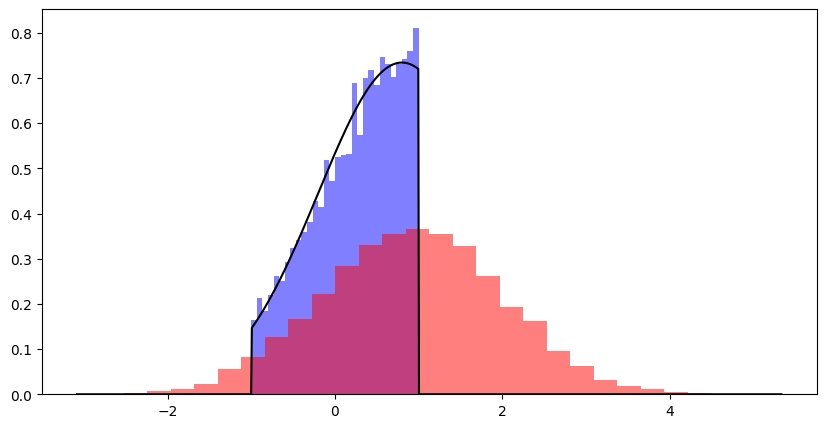

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

xlim0 = min(sequential_density_estimator_samples)
xlim1 = max(sequential_density_estimator_samples)
mu_range = np.linspace(xlim0, xlim1, 1000)

ax.hist(sequential_posterior_samples, density=True, bins=bins, color="blue", alpha=0.5)
ax.hist(sequential_density_estimator_samples, density=True, bins=bins, color="red", alpha=0.5)
ax.plot(mu_range, true_posterior_pdf(mu_range, x_observed, L=L, U=U, sigma=sigma), color="black")

plt.show()

Plot quantiles of sequential posterior for various values of $x$.

- Without training samples

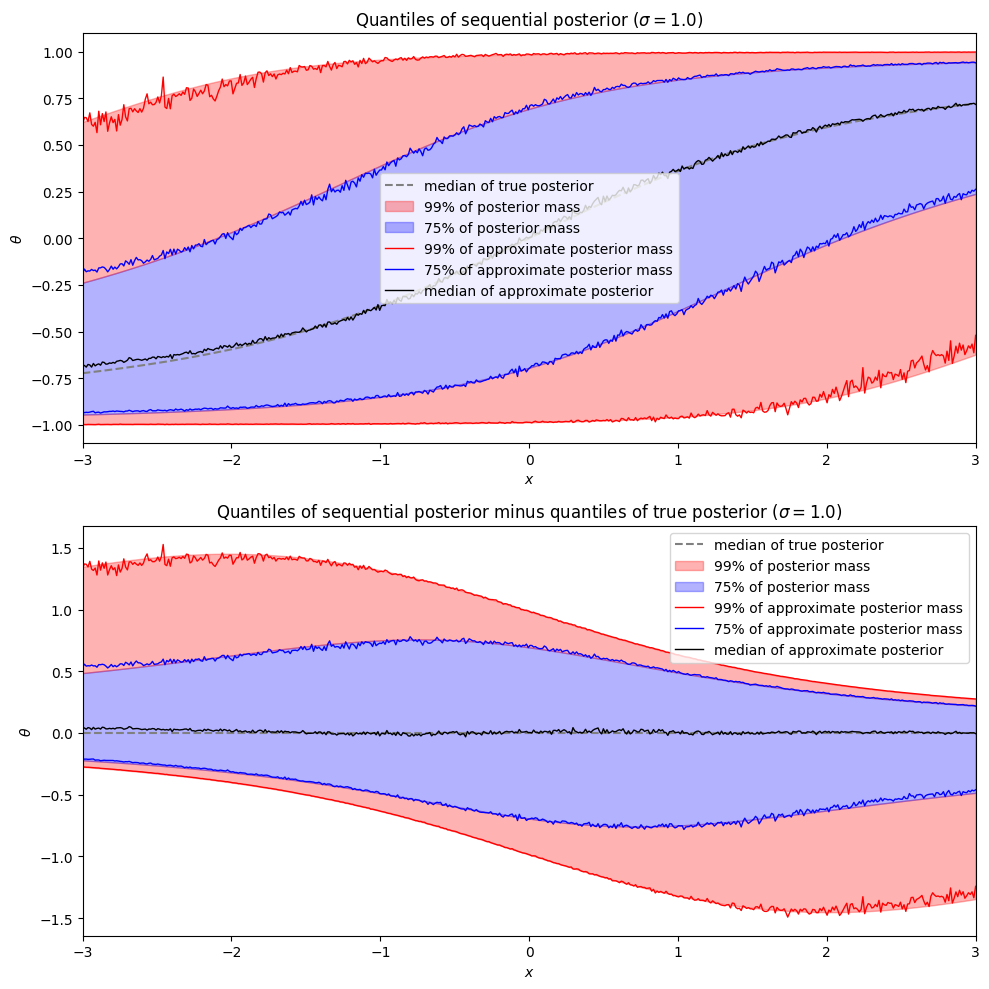

In [21]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(L-2,U+2,500)
quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)

title = "Quantiles of sequential posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[0])

title = "Quantiles of sequential posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[1])

plt.tight_layout()
plt.show()

- With training samples

In [22]:
# Retrieve samples
num_sequential_rounds = sequential_posterior_config["num_sequential_rounds"]
parameter_samples_per_round = []
data_samples_per_round = []
for r in range(num_sequential_rounds):
    parameter_samples_per_round.append(sequential_posterior_simulations[f"parameter_samples_round_{r}"].reshape(-1))
    data_samples_per_round.append(sequential_posterior_simulations[f"data_samples_round_{r}"].reshape(-1))

sequential_posterior_samples = {"parameter_samples": parameter_samples_per_round,
                                "data_samples": data_samples_per_round}

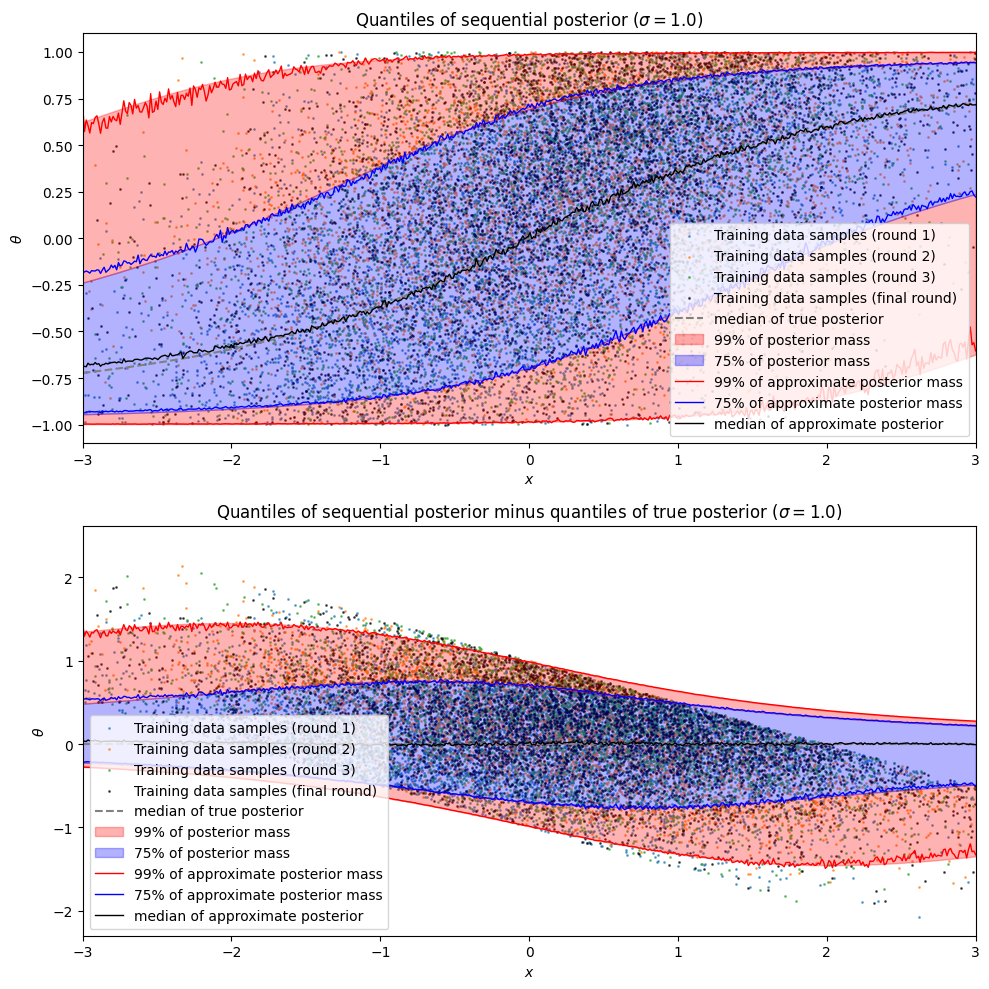

In [23]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(L-2,U+2,500)
quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)

title = "Quantiles of sequential posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[0], samples=sequential_posterior_samples)

title = "Quantiles of sequential posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, L, U, title=title, ax=ax[1], samples=sequential_posterior_samples)

plt.tight_layout()
plt.show()

Below, we plot the leakage factor (proportion of density estimator area lying outside of $[L,U]^d$) against different hyperparameters:

In [ ]:
sequential_leakage_factor_dict_ID = 1

sequential_leakage_factor_dict_name = f"sequential_leakage_factor_dict{sequential_leakage_factor_dict_ID}"
path_to_sequential_leakage_factor_dict = results_path + sequential_leakage_factor_dict_name + ".npz"
path_to_sequential_leakage_factor_dict_config = results_path + sequential_leakage_factor_dict_name + ".yaml"

# Load leakage factors
sequential_leakage_factor_dict = np.load(path_to_sequential_leakage_factor_dict)
sequential_leakage_factor_dict = dict(sequential_leakage_factor_dict)
# Load config
with open(path_to_sequential_leakage_factor_dict_config, "r") as f:
    sequential_leakage_factor_dict_config = yaml.safe_load(f)

sequential_leakage_factor_dict_config

{'L': -1.0,
 'U': 1.0,
 'd': 2,
 'd_list': None,
 'num_posterior_samples_per_leakage_factor': 10000,
 'num_posteriors_per_leakage_factor': 2,
 'num_sequential_rounds': 4,
 'num_sequential_rounds_list': [2, 4],
 'num_simulations_per_round': 5000,
 'num_simulations_per_round_list': [1000, 500],
 'sigma': 1.0,
 'use_combined_loss': True,
 'x_observed': [0.9, 0.8]}

In [ ]:
# PLOT LEAKAGE FACTORS
sequential_leakage_factor_dict

{'(num_sequential_rounds, num_simulations_per_round) = (2, 1000)': array([0.162 , 0.1339]),
 '(num_sequential_rounds, num_simulations_per_round) = (4, 500)': array([0.2528, 0.3158])}

## SBC on SNPE-C

In [65]:
sequential_sbc_ID = 0

# Load pre-trained sbc ranks
sequential_ranks_name = f"sequential_sbc_ranks{sequential_sbc_ID}"
path_to_sequential_ranks = results_path + sequential_ranks_name + ".npz"
path_to_sequential_ranks_config = results_path + sequential_ranks_name + ".yaml"
path_to_sequential_ranks_simulations = results_path + sequential_ranks_name + "_simulations" + ".npz"

# Load sbc ranks
sequential_ranks = np.load(path_to_sequential_ranks)
sequential_ranks = sequential_ranks[""]

# Load config
with open(path_to_sequential_ranks_config, "r") as f:
    sequential_ranks_config = yaml.safe_load(f)

# Load samples
sequential_ranks_simulations = np.load(path_to_sequential_ranks_simulations)

N_iter = sequential_ranks_config["N_iter"]
N_samp = sequential_ranks_config["N_samp"]

print(f"Sequential SBC config:")
sequential_ranks_config

Sequential SBC config:


{'L': -1.0,
 'N_iter': 3,
 'N_samp': 10000,
 'U': 1.0,
 'd': 1,
 'num_sequential_rounds': 2,
 'num_simulations_per_round': 1000,
 'sbc_times': [6.122042416999999, 9.246244083000002, 7.819174042],
 'sigma': 1.0,
 'test_function_name': None,
 'total_sbc_time': 23.187460542000004}

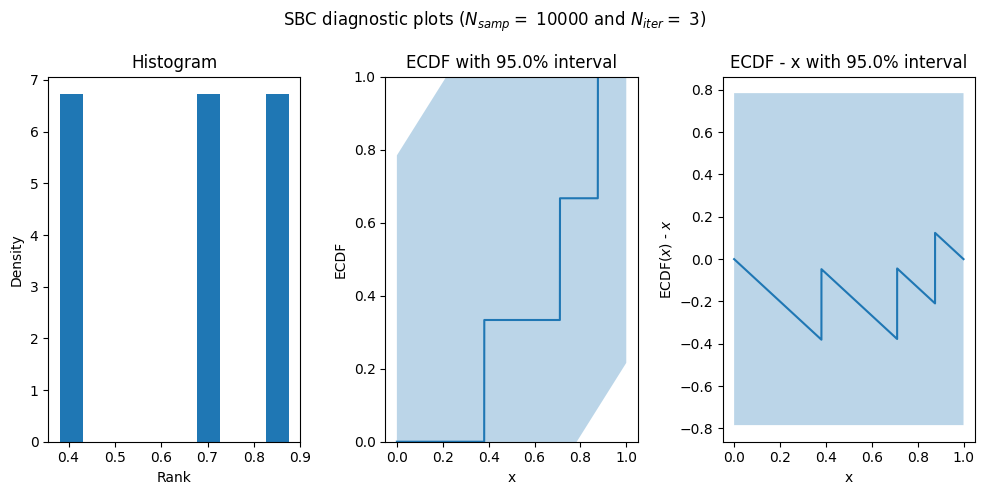

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [66]:
# TBC WITH CLUSTER RESULTS
plot_sbc_all(ranks=sequential_ranks, N_samp=N_samp)